In [122]:
%matplotlib inline
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import scipy as sp

import xgboost as xgb
#from add_features import add_features
import sklearn.cross_validation as cv
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import csv

In [123]:
workingdirect='C:\wanglf2016\kaggle\Liberty_Mutual_fireloss_prediction\data'
read_all=1
num_row=1000
if read_all==1:
    xtrain_data=pd.read_csv('../data/ruonan_data/xtrain.csv',sep=',',header=0)    
    ytrain_data=pd.read_csv('../data/ruonan_data/ytrain.csv',sep=',',header=None)    
else:
    xtrain_data=pd.read_csv('../data/ruonan_data/xtrain.csv',sep=',',header=0,\
                           skiprows=range(1,10), nrows=num_row)
    ytrain_data=pd.read_csv('../data/ruonan_data/ytrain.csv',sep=',',header=None,\
                           skiprows=range(1,10), nrows=num_row)
test_data=pd.read_csv('../data/ruonan_data/xtest.csv',sep=',',header=0,\
                      skiprows=range(1,10), nrows=100)
num_train=len(xtrain_data)
num_test=len(test_data)

print('total train data={}'.format(len(xtrain_data)))
print('total train dataouttput={}'.format(len(ytrain_data)))
print('total test data={}'.format(len(test_data)))

total train data=452061
total train dataouttput=452061
total test data=100


In [124]:
## drop 1st col
ytrain_data=ytrain_data.drop(0,axis=1)
xtrain_data=xtrain_data.drop('Unnamed: 0',axis=1)
test_data=test_data.drop('Unnamed: 0',axis=1)

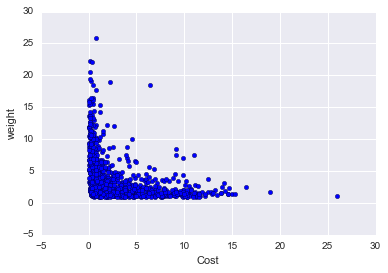

In [149]:
pos_index=[i for (i,x) in enumerate(ytrain_data[1]) if x>0 ]
weight_pos=xtrain_data['var11'][pos_index]
sign_pos=ytrain_data[1][pos_index]
unit_scale=max(weight_pos)/max(sign_pos)
weight_scaled=weight_pos*sign_pos
plt.scatter(sign_pos,weight_pos/unit_scale)
#plt.hist(weight_scaled/unit_scale,bins=50)
plt.xlabel('Cost')
plt.ylabel('weight')

In [1]:
max(pos_index)

NameError: name 'pos_index' is not defined

In [150]:
features_name=xtrain_data.columns
num_features=xtrain_data.shape[1]
print ('number total features={}'.format(num_features))
xtrain_data.head(10)

number total features=69


,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,weahter_trim43,weahter_trim44,weahter_trim45,weahter_trim46,weahter_trim47,weahter_trim48,pca_geo1,pca_geo2,pca_crime1,pca_crime2
0,Z,Z,Z,N1,Z,Z,3,1,A,3.898949,...,0.087160,0.834392,0.000000,1.488921,1.215303,0.112556,-0.851407,0.236054,-9.877135e-02,-3.076164e-01
1,Z,Z,Z,C1,Z,Z,3,2,A,3.898949,...,0.087160,0.955027,0.001751,0.271985,1.036739,0.033052,-0.774846,0.057575,-7.990080e-02,-3.345901e-01
2,3,Z,4,J3,B,B,2,4,Z,4.314082,...,0.615548,0.975133,0.003501,3.014886,1.076535,0.566352,0.012889,-0.041014,4.100035e-01,1.970156e-01
3,3,Z,4,H1,B,Z,3,4,Z,4.314082,...,0.615548,0.924869,0.000175,1.316712,0.340631,0.290147,0.414365,0.046461,2.284997e-01,3.213033e-01
4,Z,Z,Z,H1,Z,Z,2,4,A,3.898949,...,4.425052,1.196297,7.193384,1.629389,1.016120,1.313732,-0.264987,0.017974,2.049395e-01,1.430427e-01
5,Z,Z,Z,A1,Z,Z,4,2,A,3.824453,...,0.922684,1.115874,1.295495,0.794668,1.010759,1.173893,0.371219,0.374754,2.294233e-01,-4.448948e-02
6,Z,Z,Z,H2,Z,Z,3,3,A,3.898949,...,0.479860,1.135980,0.000058,0.086500,1.135300,0.789888,0.550118,-0.234879,-4.334570e-13,-3.399755e-13
7,Z,Z,Z,E3,Z,Z,3,3,A,4.171214,...,0.920062,0.993951,1.043171,0.001166,0.886631,0.003998,0.312152,-0.256252,7.984971e-01,-1.958333e-01
8,Z,Z,Z,M1,Z,Z,3,1,B,4.039930,...,0.786037,1.075662,0.000992,3.933963,1.129114,2.222157,0.194191,-0.054439,-3.418484e-02,1.571250e-01
9,Z,Z,Z,R3,Z,Z,3,1,A,4.039930,...,0.087160,0.894710,0.000000,0.300868,1.228087,0.037004,-3.454792,-0.177641,-9.877135e-02,-3.076164e-01


In [151]:
num_fire=len([ytrain_data>0])
print ('True signal percentage= {}'.format(num_fire/num_train))

True signal percentage= 2.21209084615e-06


In [152]:
num_miss_col=np.sum(xtrain_data.isnull())
num_miss_row=np.sum(xtrain_data.isnull().any(axis=1))
print ('number of missing col={}'.format(num_miss_col))
print ('number of missing row={}'.format(num_miss_row))

number of missing col=var1                   0
var2                   0
var3                   0
var4                   0
var5                   0
var6                   0
var7                   0
var8                   0
var9                   0
var10                  0
var11                  0
var12             355042
var13                  0
var14             290466
var15              98856
var16             361693
var17                  0
weahter_trim1          0
weahter_trim2          0
weahter_trim3          0
weahter_trim4          0
weahter_trim5          0
weahter_trim6          0
weahter_trim7          0
weahter_trim8          0
weahter_trim9          0
weahter_trim10         0
weahter_trim11         0
weahter_trim12         0
weahter_trim13         0
                   ...  
weahter_trim23         0
weahter_trim24         0
weahter_trim25         0
weahter_trim26         0
weahter_trim27         0
weahter_trim28         0
weahter_trim29         0
weahter_trim30         0
wea

In [153]:
# fill NA with Mean
float_feaature_list=[]
for (i,x) in enumerate(features_name):
    if (xtrain_data[x].dtype==float):
        float_feaature_list.append(i)
        xtrain_data[x].fillna(xtrain_data[x].mean(),inplace=True)
float_feaature_name=features_name[float_feaature_list]

In [8]:
float_feaature_name

Index([u'var10', u'var11', u'var12', u'var13', u'var14', u'var15', u'var16',
       u'var17', u'weahter_trim1', u'weahter_trim2', u'weahter_trim3',
       u'weahter_trim4', u'weahter_trim5', u'weahter_trim6', u'weahter_trim7',
       u'weahter_trim8', u'weahter_trim9', u'weahter_trim10',
       u'weahter_trim11', u'weahter_trim12', u'weahter_trim13',
       u'weahter_trim14', u'weahter_trim15', u'weahter_trim16',
       u'weahter_trim17', u'weahter_trim18', u'weahter_trim19',
       u'weahter_trim20', u'weahter_trim21', u'weahter_trim22',
       u'weahter_trim23', u'weahter_trim24', u'weahter_trim25',
       u'weahter_trim26', u'weahter_trim27', u'weahter_trim28',
       u'weahter_trim29', u'weahter_trim30', u'weahter_trim31',
       u'weahter_trim32', u'weahter_trim33', u'weahter_trim34',
       u'weahter_trim35', u'weahter_trim36', u'weahter_trim37',
       u'weahter_trim38', u'weahter_trim39', u'weahter_trim40',
       u'weahter_trim41', u'weahter_trim42', u'weahter_trim43',
       

######  ordinal feature: fill missing with median; convert to  float

In [154]:
ord_feature=['var1', 'var3', 'var7', 'var8']
for feature in ord_feature:
    xtrain_data[feature]=xtrain_data[feature].replace('Z',np.nan)
for feature in ord_feature:
    med=xtrain_data[feature].astype(float).median()
    xtrain_data[feature]=xtrain_data[feature].replace(np.nan,med)
for feature in ord_feature:
    xtrain_data[feature]=xtrain_data[feature].astype(float)    

######nominal data type

In [155]:
nominal_feature=['var2', 'var4', 'var5', 'var6','var9']
for feature in nominal_feature:
    xtrain_data[feature]=xtrain_data[feature].astype('category')
category_data=xtrain_data[nominal_feature].T.to_dict().values()

In [ ]:
weight_train=xtrain_data['var11']
xtrain_data=xtrain_data.drop(nominal_feature+['var11'],axis=1)

In [157]:
xtrain_data.head(10)

,var1,var3,var7,var8,var10,var12,var13,var14,var15,var16,...,weahter_trim43,weahter_trim44,weahter_trim45,weahter_trim46,weahter_trim47,weahter_trim48,pca_geo1,pca_geo2,pca_crime1,pca_crime2
0,3,3,3,1,3.898949,3.099522,0.000000,0.000000,29.000000,73.423978,...,0.087160,0.834392,0.000000,1.488921,1.215303,0.112556,-0.851407,0.236054,-9.877135e-02,-3.076164e-01
1,3,3,3,2,3.898949,3.099522,1.268636,0.224294,23.000000,73.423978,...,0.087160,0.955027,0.001751,0.271985,1.036739,0.033052,-0.774846,0.057575,-7.990080e-02,-3.345901e-01
2,3,4,2,4,4.314082,2.719846,2.482178,0.000000,31.190926,100.000000,...,0.615548,0.975133,0.003501,3.014886,1.076535,0.566352,0.012889,-0.041014,4.100035e-01,1.970156e-01
3,3,4,3,4,4.314082,3.520478,2.054144,0.000000,22.000000,100.000000,...,0.615548,0.924869,0.000175,1.316712,0.340631,0.290147,0.414365,0.046461,2.284997e-01,3.213033e-01
4,3,3,2,4,3.898949,3.099522,0.832555,0.224294,21.000000,73.423978,...,4.425052,1.196297,7.193384,1.629389,1.016120,1.313732,-0.264987,0.017974,2.049395e-01,1.430427e-01
5,3,3,4,2,3.824453,3.099522,1.268636,0.000000,11.000000,73.423978,...,0.922684,1.115874,1.295495,0.794668,1.010759,1.173893,0.371219,0.374754,2.294233e-01,-4.448948e-02
6,3,3,3,3,3.898949,3.099522,0.832555,0.224294,17.000000,73.423978,...,0.479860,1.135980,0.000058,0.086500,1.135300,0.789888,0.550118,-0.234879,-4.334570e-13,-3.399755e-13
7,3,3,3,3,4.171214,3.099522,1.835019,0.224294,28.000000,73.423978,...,0.920062,0.993951,1.043171,0.001166,0.886631,0.003998,0.312152,-0.256252,7.984971e-01,-1.958333e-01
8,3,3,3,1,4.039930,3.099522,1.268636,0.000000,44.000000,73.423978,...,0.786037,1.075662,0.000992,3.933963,1.129114,2.222157,0.194191,-0.054439,-3.418484e-02,1.571250e-01
9,3,3,3,1,4.039930,3.099522,1.177410,0.224294,26.000000,73.423978,...,0.087160,0.894710,0.000000,0.300868,1.228087,0.037004,-3.454792,-0.177641,-9.877135e-02,-3.076164e-01


In [ ]:
from sklearn.feature_extraction import DictVectorizer as DV
vectorizer = DV( sparse = False )
vec_x_train = vectorizer.fit_transform(category_data)
#xtrain_data = np.hstack(( xtrain_data.as_matrix(), vec_x_train ))

In [97]:
float_feaature_name[0:10]

Index([u'var10', u'var11', u'var12', u'var13', u'var14', u'var15', u'var16',
       u'var17', u'weahter_trim1', u'weahter_trim2'],
      dtype='object')

###### data split

In [158]:
weather_names=[]
weather_list=[]
geo_names=[]
geo_list=[]
crime_names=[]
crime_list=[]
for (i,x) in enumerate(features_name):
    if (re.search('^wea',x)!=None):
        weather_names.append(x)
        weather_list.append(i)
    if (re.search('^geo',x)!=None):
        geo_names.append(x)
        geo_list.append(i)
    if (re.search('^cri',x)!=None):
        crime_names.append(x)
        crime_list.append(i)
weather_data=xtrain_data[weather_list]
crime_data=xtrain_data[crime_list]
geo_data=xtrain_data[geo_list]

IndexError: indices are out-of-bounds

In [36]:
xtrain_data.iloc[1:20,1:25]

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var15,var16,var17,weahter_trim1,weahter_trim2,weahter_trim3,weahter_trim4,weahter_trim5,weahter_trim6,weahter_trim7
1,3,Z,3,C1,Z,Z,3,2,A,3.898949,...,23.000000,73.423978,100.000000,0.000000,1.103729,0.007736,0.841267,1.085206,1.010997,1.613586
2,3,Z,4,J3,B,B,2,4,Z,4.314082,...,31.190926,100.000000,0.000000,0.000000,1.291792,0.000000,0.000000,1.246473,1.024891,0.406362
3,3,Z,4,H1,B,Z,3,4,Z,4.314082,...,22.000000,100.000000,100.000000,0.000000,1.302432,0.000000,0.043718,1.243298,1.026034,5.890540
4,3,Z,3,H1,Z,Z,2,4,A,3.898949,...,21.000000,73.423978,2.421308,0.000000,1.178029,0.167968,0.748524,1.169077,1.004333,0.256244
5,3,Z,3,A1,Z,Z,4,2,A,3.824453,...,11.000000,73.423978,80.000000,0.000000,0.862954,0.642357,0.000000,0.862239,0.999594,0.378090
6,3,Z,3,H2,Z,Z,3,3,A,3.898949,...,17.000000,73.423978,86.187845,0.000000,1.164071,0.008105,0.000000,1.156741,1.020539,1.573600
7,3,Z,3,E3,Z,Z,3,3,A,4.171214,...,28.000000,73.423978,100.000000,0.000000,1.064529,0.000000,0.346228,1.080006,1.023549,1.179931
8,3,Z,3,M1,Z,Z,3,1,B,4.039930,...,44.000000,73.423978,64.285714,0.000000,1.033441,0.283406,0.000000,1.018818,1.009057,2.462946
9,3,Z,3,R3,Z,Z,3,1,A,4.039930,...,26.000000,73.423978,100.000000,0.000000,1.129245,0.000000,1.192119,1.106395,1.011848,0.424069
10,3,Z,3,I1,Z,Z,3,2,A,3.898949,...,35.000000,73.423978,96.052632,0.000000,1.310436,0.000000,19.285895,1.296677,0.974747,0.000000


In [17]:
geo_data.head(2)

""
0
1


In [18]:
crime_data.head(2)

""
0
1


In [19]:
weather_data.head(2)

,weahter_trim1,weahter_trim2,weahter_trim3,weahter_trim4,weahter_trim5,weahter_trim6,weahter_trim7,weahter_trim8,weahter_trim9,weahter_trim10,...,weahter_trim39,weahter_trim40,weahter_trim41,weahter_trim42,weahter_trim43,weahter_trim44,weahter_trim45,weahter_trim46,weahter_trim47,weahter_trim48
0,0,1.129245,0,1.192119,1.106395,1.011848,0.424069,0,0,0,...,1.071992,0.985773,1.090829,1.016216,0.087160,0.894710,0.000000,0.300868,1.228087,0.037004
1,0,1.310436,0,19.285895,1.296677,0.974747,0.000000,0,0,0,...,1.171250,1.200395,1.171352,1.093474,0.125472,1.045504,19.271952,1.617166,1.201075,0.152336


In [35]:
xtrain_num_data.head(3)

,var10,var11,var12,var13,var14,var15,var16,var17,weahter_trim1,weahter_trim2,...,weahter_trim43,weahter_trim44,weahter_trim45,weahter_trim46,weahter_trim47,weahter_trim48,pca_geo1,pca_geo2,pca_crime1,pca_crime2
0,4.039930,1492.246628,3.091271,1.177410,0.225342,26,73.67616,100.000000,0.000000,1.129245,...,0.087160,0.894710,0.000000,0.300868,1.228087,0.037004,-3.454792,-0.177641,-0.098771,-0.307616
1,3.898949,616.441400,3.091271,1.048147,0.000000,35,73.67616,96.052632,0.000000,1.310436,...,0.125472,1.045504,19.271952,1.617166,1.201075,0.152336,-1.043316,-0.073276,0.152420,-0.004554
2,3.898949,609.327498,3.091271,0.000000,0.225342,60,73.67616,87.394958,3.076415,0.949404,...,0.622892,0.965080,0.000058,0.225651,1.129320,0.615880,-0.098136,0.326503,-0.450910,-0.133991


###### collreation study, not used for train

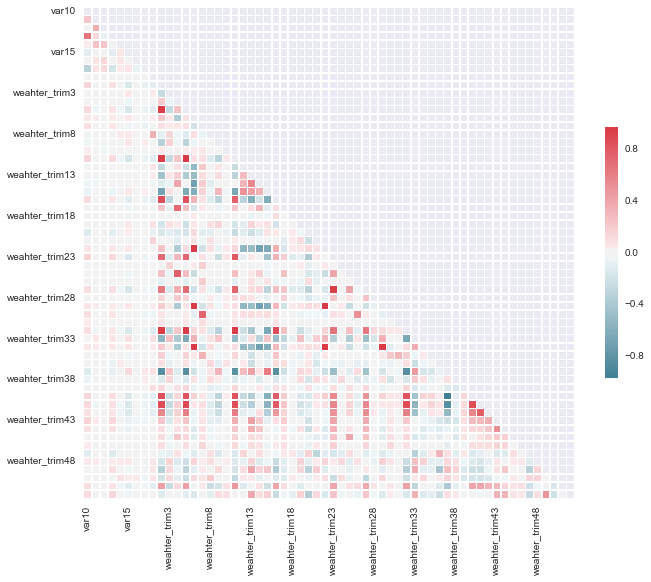

In [44]:
#xtrain_data.corr()
xtrain_num_data=xtrain_data[float_feaature_list]
xtrain_num_data=xtrain_num_data/np.std(xtrain_num_data)
corr= xtrain_num_data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

# sns.graphics.plot_corr(corr_matrix, xnames=xtrain_data.names)
# plt.show()

# data train

In [187]:
import sklearn
import sklearn.cross_validation
from sklearn.linear_model import LogisticRegression
#ytrain=ytrain_data.as_matrix()
ytrain= np.asarray(ytrain_data,dtype="float")
ytrain[ytrain>0]=1
#ytrain=list(ytrain_data.values)
np.random.seed(1337)
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split( \
       xtrain_data, ytrain)

In [171]:
ixx=list(X_train.index)
weight_sub_train=weights[ixx]
ixx=list(X_test.index)
weight_sub_test=weights[ixx]

In [188]:
y_train=np.asarray(y_train)

In [161]:
import sklearn.metrics
import time
def evaluate_model(clf):
    """Scores a model using log loss with the created train and test sets."""
    start = time.time()
    clf.fit(X_train, y_train)
    print ("Train score:", sklearn.metrics.roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
    print ("Test score:", sklearn.metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
    print ("Total time:", time.time() - start)

In [162]:
from __future__ import division
import pandas as pd
import numpy as np

def weighted_gini(act,pred,weight):
    df = pd.DataFrame({"act":act,"pred":pred,"weight":weight})
    df = df.sort_values('pred',ascending=False)
    df["random"] = (df.weight / df.weight.sum()).cumsum()
    total_pos = (df.act * df.weight).sum()
    df["cum_pos_found"] = (df.act * df.weight).cumsum()
    df["lorentz"] = df.cum_pos_found / total_pos
    n = df.shape[0]
#df["gini"] = (df.lorentz - df.random) * df.weight
#return df.gini.sum()
    gini = sum(df.lorentz[1:].values * (df.random[:-1])) - sum(df.lorentz[:-1].values * (df.random[1:]))
    return gini
def normalized_weighted_gini(act,pred,weight):
    return weighted_gini(act,pred,weight) / weighted_gini(act,act,weight)

In [102]:
##test only
var11=[1, 2, 5, 4, 3]
pred=[0.1, 0.4, 0.3, 1.2, 0.0]
target=[0, 0, 1, 0, 1]
weighted_gini(target,pred,var11)
normalized_weighted_gini(target,pred,var11)
#-0.82142857142857195

-0.82142857142857195

###### matlab version

In [117]:
# function gini = weighted_gini(act,pred,weight)

# [~, I] = sort(pred);
# weight = weight(I);
# act = act(I);

# drandom = cumsum(weight);
# drandom = drandom / drandom(end);
# lorentz = cumsum(act.*weight);
# lorentz = lorentz / lorentz(end);

# gini = sum(lorentz(2:end).*drandom(1:end-1)) - sum(lorentz(1:end-1).*drandom(2:end));


# function f = normalized_weighted_gini(act,pred,weight)
# f = weighted_gini(act,pred,weight) / weighted_gini(act,act,weight);

In [163]:
def compare_listcomp(x, y):
    return [1 for i, j in zip(x, y) if i == j]

import pylab as pl
import sklearn.metrics as skm
import math
def summary_model(clf):
    test_pred=clf.predict(X_test)
    train_pred=clf.predict(X_train)
    accuracy_test=1.0*sum(compare_listcomp(test_pred,y_test))/len(y_test)
    accuracy_train=1.0*sum(compare_listcomp(train_pred,y_train))/len(y_train)
    print("prediction accuaracy on the trainning data= %f" %(accuracy_train))
    print("prediction accuaracy on the test      data= %f" %(accuracy_test))
    print("mean accuracy score for validation set = %f" %(clf.score(X_train, y_train)))
    print("mean accuracy score for test set = %f" %(clf.score(X_test, y_test)))
    test_cm = skm.confusion_matrix(y_test,test_pred)
    pl.matshow(test_cm)
    pl.title('Confusion matrix for test data')
    pl.colorbar()
    pl.show()
    print('confusing table,\n')
    print(test_cm)
    test_truth=y_test
    # Accuracy
    print("Accuracy = %f" %(clf.accuracy_score(test_truth,test_pred)))
    # Precision
    print("Precision = %f" %(clf.precision_score(test_truth,test_pred)))
    # Recall
    print("Recall = %f" %(clf.recall_score(test_truth,test_pred)))
    # F1 Score
    print("F1 score = %f" %(clf.f1_score(test_truth,test_pred)))

In [104]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()
#evaluate_model(logit)
logit.fit(X_train,y_train)
summary_model(logit)

C:\Users\wanglf\Anaconda2\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: 

In [184]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(X_train,y_train)
y_out = ols.predict(X_test)
ols.intercept_

array([-0.00158773])

In [185]:
num=y_test.shape[0]
y_test=np.reshape(y_test,num)
y_out=np.reshape(y_out,num)
gini_score=normalized_weighted_gini(y_test,y_out,weight_sub_test)
print('gini score={}'.format(gini_score))

In [110]:
folds = 5 
param = {}
param['objective'] ='binary:logitraw'  # 'reg:logistic' # '
param['silent'] = 1
param['nthread'] = 1
param['eval_metric'] = 'auc' #'rmse'
param['bst:max_depth'] = 6
param['min_child_weight']=1
param['gamma']=0
param['subsample']=1    # = c(0.5, 0.75, 1),
param['colsample_bytree']=0.9  # = c(0.6, 0.8, 1))
param['learning_rate']=0.2
weights=np.asarray(weight_train)
num_round = 100 # Number of boosted trees
estimate_performance_xgboost(xtrain_data, ytrain,weights, param, num_round, folds)

gini_score=0.285431342001
gini_score=0.170238173956
gini_score=0.224819514766
gini_score=0.157141956651
gini_score=0.209894017371
------------------------------------------------------
mean Gimi =0.209505000949 with std=0.0453503407772


##### grid scan

In [201]:
    param['objective'] ='binary:logitraw'  
    param['bst:max_depth'] = 1
    param['min_child_weight']=1
    param['gamma']=0
    param['subsample']=1    # = c(0.5, 0.75, 1),
    param['colsample_bytree']=0.9  # = c(0.6, 0.8, 1))
    param['learning_rate']=0.1
    num_round=70
    
    f=open("summary_bst_scan.txt","a")
    f.write('tuning parameters=')
    f.write('\n')
    for key, values in param.items():
        f.write('param {}={}'.format(key,values))
        f.write('\n')
    f.write('nfolds=%f' %(folds))
    f.write('\n')
    f.write('num_round=%f' %(num_round))
    f.write('\n')
    f.close()
#    max_depth_values=[1]
#     min_child_weight_values=[1,3,5]
#     # max_depth_values=[5]
#    min_child_weight_values=[1]
    #
#     for x in max_depth_values:
#         for y in min_child_weight_values:
#             f=open("summary_bst_scan.txt","a")
#             f.write('\n')
#             f.write('-------------')
#             f.write('\n')
#             param['max_depth']=x
#             param['min_child_weight']=y
#             f.write('param {}={}'.format('max_depth',x))
#             f.write('\n')
#             f.write('param {}={}'.format('mini_child_weight',y))
#             f.write('\n')
#             f.write('--------------')
#             f.write('\n')
#             f.close()
#     gamma_vlaues=[10,100]
#     for x in gamma_vlaues:
#             f=open("summary_bst_scan.txt","a")
#             f.write('\n')
#             f.write('-------------')
#             f.write('\n')
#             param['gamma']=x
#             f.write('param {}={}'.format('gamma',x))
#             f.write('\n')
#             f.write('--------------')
#             f.write('\n')
#             f.close()
#     subsample_values=[0.6,0.8,0.9,1]
#     colsample_bytree_values=[0.6,0.8,0.9,1]
# #     subsample_values=[1]
# #     colsample_bytree_values=[0.5,0.7]
#     for x in subsample_values:
#         for y in colsample_bytree_values:
#             f=open("summary_bst_scan.txt","a")
#             f.write('\n')
#             f.write('-------------')
#             f.write('\n')
#             param['subsample']=x
#             param['colsample_bytree']=y
#             f.write('param {}={}'.format('subsample',x))
#             f.write('\n')
#             f.write('param {}={}'.format('colsample_bytree',y))
#             f.write('\n')
#             f.write('--------------')
#             f.write('\n')
#             f.close()
    num_round_values =[150,180,200,250]
    num_round_values =[100,120,130,140]
    num_round_values =[60,70,80,90]
    for x in num_round_values:
            f=open("summary_bst_scan.txt","a")
            f.write('\n')
            f.write('-------------')
            f.write('\n')
            num_round =x
            f.write('num_round={}'.format(x))
            f.write('\n')
            f.write('--------------')
            f.write('\n')
            f.close()

            estimate_performance_xgboost(xtrain_data, ytrain,weights, param, num_round, folds)
    

gini_score=0.328896536698
gini_score=0.263241575476
gini_score=0.316520556411
gini_score=0.338260719521
gini_score=0.290618123486
------------------------------------------------------
mean Gimi =0.307507502319 with std=0.0273101069226
gini_score=0.333678232567
gini_score=0.271915720337
gini_score=0.314015045411
gini_score=0.32958001903
gini_score=0.294032342159
------------------------------------------------------
mean Gimi =0.308644271901 with std=0.0230492728447
gini_score=0.331077400843
gini_score=0.2688596421
gini_score=0.299555639421
gini_score=0.309071298017
gini_score=0.289358183866
------------------------------------------------------
mean Gimi =0.299584432849 with std=0.0206416927973
gini_score=0.327966549001
gini_score=0.277171200234
gini_score=0.282196272775
gini_score=0.303534913683
gini_score=0.285485816958
------------------------------------------------------
mean Gimi =0.29527095053 with std=0.0186096332289


In [196]:
def estimate_performance_xgboost(X,labels,weights, param, num_round, folds):
    '''
    Cross validation for XGBoost performance
    '''
    # Load training data
#     f=open("summary_bst_scan.txt","a")
#     X, labels, weights = get_training_data(training_file)
    f=open("summary_bst_scan.txt","a")
    # Cross validate
    kf = cv.KFold(labels.size, n_folds=folds, random_state=4234)
    npoints  =30
    # Dictionary to store all the AMSs
    ams_best_idall_AMS = {}
    all_GINI = []
    summay_table=[]
#     for curr in range(npoints):
#         all_AMS[curr] = []
    # These are the cutoffs used for the XGBoost predictions
    cutoffs  = sp.linspace(0.10, 0.40, npoints)
    for train_indices, test_indices in kf:
        X_train, X_test = X.loc[train_indices], X.loc[test_indices]
        y_train, y_test = labels[train_indices], labels[test_indices]
        w_train, w_test = weights[train_indices], weights[test_indices]

        # Rescale weights so that their sum is the same as for the entire training set
        w_train *= (sum(weights) / sum(w_train))
        w_test  *= (sum(weights) / sum(w_test))

#         sum_wpos = sum(w_train[y_train == 1])
#         sum_wneg = sum(w_train[y_train == 0])
        sum_wpos = sum( weights[i] for i in range(len(y_train)) if y_train[i] > 0.0  )
        sum_wneg = sum( weights[i] for i in range(len(y_train)) if y_train[i] == 0.0  )    
        if (sum_wneg>  sum_wpos*100000):
            sum_wpos=1000*sum_wneg
        # construct xgboost.DMatrix from numpy array, treat -999.0 as missing value
#        xgmat = xgb.DMatrix(X_train, label=y_train, missing=-999.0, weight=w_train)
        xgmat = xgb.DMatrix(X_train, label=y_train, weight=w_train)

        # scale weight of positive examples
        param['scale_pos_weight'] = sum_wneg / sum_wpos
        # you can directly throw param in, though we want to watch multiple metrics here
        plst = param.items()#+[('eval_metric', 'ams@0.15')]

        watchlist = []#[(xgmat, 'train')]
        bst = xgb.train(plst, xgmat, num_round, watchlist)

        # Construct matrix for test set
#        xgmat_test = xgb.DMatrix(X_test, missing=-999.0)
        xgmat_test = xgb.DMatrix(X_test)
        y_out = bst.predict(xgmat_test)
        num=y_test.shape[0]
        y_test=np.reshape(y_test,num)
#         print((y_test).shape)
        gini_score=normalized_weighted_gini(y_test,y_out,w_test)
        print('gini_score={}'.format(gini_score))
        f.write('gini_score={}'.format(gini_score))
        f.write('\n')
        all_GINI.append(gini_score)
    print ("------------------------------------------------------")
    print ("mean Gimi ={} with std={}".format(sp.mean(all_GINI),sp.std(all_GINI)))
    f.write("mean Gimi ={} with std={}".format(sp.mean(all_GINI),sp.std(all_GINI)))
    f.write('\n')
    f.close()
